#Predict Heart Failure
Task Details:

Create a model to assess the likelihood of a death by heart failure event.
This can be used to help hospitals in assessing the severity of patients with cardiovascular diseases.

resource:
https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records

![](http://)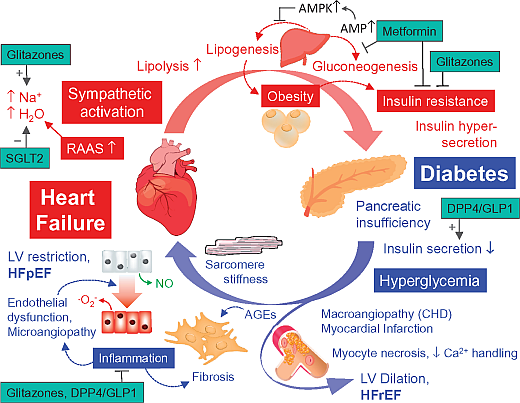

Attribute Information:

Thirteen (13) clinical features:

- age: age of the patient (years)
- anaemia: decrease of red blood cells or hemoglobin (boolean)
- high blood pressure: if the patient has hypertension (boolean)
- creatinine phosphokinase (CPK): level of the CPK enzyme in the blood (mcg/L)
- diabetes: if the patient has diabetes (boolean)
- ejection fraction: percentage of blood leaving the heart at each contraction (percentage)
- platelets: platelets in the blood (kiloplatelets/mL)
- sex: woman or man (binary)
- serum creatinine: level of serum creatinine in the blood (mg/dL)
- serum sodium: level of serum sodium in the blood (mEq/L)
- smoking: if the patient smokes or not (boolean)
- time: follow-up period (days)
- [target] death event: if the patient deceased during the follow-up period (boolean)

* Sex - Gender of patient Male = 1, Female =0
* Age - Age of patient
* Diabetes - 0 = No, 1 = Yes
* Anaemia - 0 = No, 1 = Yes
* High_blood_pressure - 0 = No, 1 = Yes
* Smoking - 0 = No, 1 = Yes
* DEATH_EVENT - 0 = No, 1 = Yes

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
pip install catboost

In [ ]:
pip install bayesian-optimization

In [ ]:
pip install xverse

In [ ]:

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")
from datetime import datetime as dt

#!pip install xverse
#import libraries
from xverse.ensemble import VotingSelector

#Outlier
from scipy import stats

# Import modules
import xgboost
import lightgbm
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, plot_confusion_matrix


pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')


In [ ]:
df1 = pd.read_csv('/kaggle/input/heart-failure-clinical-data/heart_failure_clinical_records_dataset.csv')
df1.head()

In [ ]:
pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [ ]:
import pandas_profiling
from pandas_profiling import ProfileReport

In [ ]:
profile = ProfileReport(df1, title='Pandas Profiling Report', html={'style':{'full_width':True}})
#profile.to_widgets()
profile.to_notebook_iframe()

##Feature selection 
according to ProfileReport.
Age,ejection fraction,serum_creatinine,time out of 13 features are highly correlated with death_event.
Therefore, drop other unnecessary features. However do not forget this is not a feature selection. This is like a browse a pub, we do not choose our drink yet !!!

Voting Selector using Xuniverse
 This method scored features for each algorithm to select the best one with minimum effort.

In [ ]:
X = df1.drop(columns =["DEATH_EVENT"])
Y = df1["DEATH_EVENT"]

In [ ]:
#Fit the model
clf = VotingSelector()
clf.fit(X, Y)

In [ ]:
#Selected features
clf.feature_importances_
print(clf.feature_importances_['Random_Forest'].nlargest(10).plot(kind='barh'))
plt.show()

In [ ]:
#Selected features with 6 models 
clf.feature_importances_

In [ ]:
#Name tobe selected features
clf.feature_importances_['Variable_Name'][0],clf.feature_importances_['Variable_Name'][1],clf.feature_importances_['Variable_Name'][3],clf.feature_importances_['Variable_Name'][4]

In [ ]:
df2 = df1.drop(columns =["high_blood_pressure", "anaemia", "diabetes","sex","smoking","platelets","creatinine_phosphokinase","age"])##Outlier Detection


Lets find out, Data is how much distributed !!
**and removal**
Since Number of observations are very less, we will eliminate less outlier values.

In [ ]:
df2.columns

##Outlier Detection
Lets find out, Data is how much distributed !!
**and removal**
Since Number of observations are very less, we will eliminate less outlier values.

In [ ]:
plt.figure(figsize=(5,5))
sns.boxplot(y="serum_creatinine", x="DEATH_EVENT", data=df2)
plt.xticks(rotation=90)

In [ ]:
plt.figure(figsize=(5,5))
sns.boxplot(y="ejection_fraction", x="DEATH_EVENT", data=df2)
plt.xticks(rotation=90)

In [ ]:
plt.figure(figsize=(5,5))
sns.boxplot(y="serum_sodium", x="DEATH_EVENT", data=df2)
plt.xticks(rotation=90)

In [ ]:
plt.figure(figsize=(5,5))
sns.boxplot(y="time", x="DEATH_EVENT", data=df2)
plt.xticks(rotation=90)

In [ ]:
z = np.abs(stats.zscore(df2))
#show only those values having z > threshold
threshold = 3
df2_edited_z = df2[(z < 3).all(axis=1)]
#keeping only those values in boston_df_edited where z score is lower than 3.

In [ ]:
df2.shape

In [ ]:
df2_edited_z.shape

As we can see that by this way less records which are outliers. Which is acceptable. No need of outlier removal.

**Data Modeling**

In [ ]:
test_size = 0.2
seed = 7
score = 'accuracy'

In [ ]:
# Implementation of different ML Algorithms
def models(X_train, Y_train,score):
    clfs = []
    result = []
    names = []
    clfs.append(('LR', LogisticRegression()))
    clfs.append(('LDA', LinearDiscriminantAnalysis()))
    clfs.append(('KNN', KNeighborsClassifier()))
    clfs.append(('CART', DecisionTreeClassifier(criterion="gini",max_features="log2",max_depth=2,random_state=1)))
    clfs.append(('NB', GaussianNB()))
    clfs.append(('GB', GradientBoostingClassifier(learning_rate=0.1,max_depth=2)))
    clfs.append(('XGB', XGBClassifier()))
    clfs.append(('CBC', CatBoostClassifier()))
    clfs.append(('RFC', RandomForestClassifier(max_depth=4,max_features="log2",random_state=4)))
    clfs.append(('SVM', SVC()))
    for algo_name, clf in clfs:
        k_fold = model_selection.KFold(n_splits=10, random_state=seed)
        cv_score = model_selection.cross_val_score(clf, X_train, Y_train, cv=k_fold, scoring=score)
        #result = "%s: %f (%f)" % (algo_name, cv_score.mean(), cv_score.std())
        result.append((algo_name,cv_score.mean(), cv_score.std()))
        names.append(algo_name)
    return (result)

**Train Test Split**

In [ ]:
X_all = df2.drop(columns =["DEATH_EVENT"])
Y_all = df2["DEATH_EVENT"]

In [ ]:
X_train_all, X_test_all, Y_train_all, Y_test_all = model_selection.train_test_split(X_all, Y_all, test_size=test_size, random_state=seed)

In [ ]:
models(X_train_all, Y_train_all, score)

Lets fine tune best fit model

In [ ]:
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

xgb = XGBClassifier(learning_rate=0.01, n_estimators=1000, objective='binary:logistic')

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 0)

grid = GridSearchCV(estimator=xgb, param_grid=params, n_jobs=4, 
                    cv=skf.split(X_train_all,Y_train_all), verbose=0 )

grid.fit(X_train_all,Y_train_all,early_stopping_rounds=30,eval_set=[(X_test_all, Y_test_all)])
p2x = grid.best_estimator_.predict(X_test_all)
s2x=accuracy_score(Y_test_all,p2x)

plot_confusion_matrix(grid.best_estimator_, X_test_all, Y_test_all)
plt.show()

In [ ]:
print("Extra Gradient Booster Classifier Success Rate :", "{:.2f}%".format(100*s2x))